In [301]:
import os
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Если нужно зафиксировать результаты
# random.seed(162)
# np.random.seed(162)
# torch.manual_seed(162)
# torch.cuda.manual_seed(162)
torch.backends.cudnn.deterministic = True

## Предобработка данных

Прочтём и преобразуем наши данные

In [302]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.Grayscale(),
    transforms.ToTensor(),        
])

In [303]:
dataset_path = '../../../MLUniversity/work1/Dataset/BrowserLogos_64'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

In [304]:
print(len(dataset))

1000


In [305]:
# Получаем индексы всех изображений и меток
indices = list(range(len(dataset)))
labels = [dataset[i][1] for i in indices]
TEST_SIZE = 0.2
TRAIN_SIZE = 0.8

# Разбиваем данные
train_indices, test_indices = train_test_split(indices, train_size=TRAIN_SIZE, test_size=TEST_SIZE, stratify=labels, shuffle=True)

# Создание поднаборов данных
train_subset = torch.utils.data.Subset(dataset, train_indices)
test_subset = torch.utils.data.Subset(dataset, test_indices)


In [306]:
TRAIN_BATCH_SIZE = int(len(dataset) * TRAIN_SIZE)
TEST_BATCH_SIZE = int(len(dataset) * TEST_SIZE)

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=TRAIN_BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=TEST_BATCH_SIZE, shuffle=False)


Создаём обучающую и тестовую выборку

In [307]:
# Извлечение обучающего и тестового тензоров
for images, labels in train_loader:
    X_train = images  # Тензор размера [800, 1, 64, 64]
    y_train = labels  # Метки

for images, labels in test_loader:
    X_test = images  # Тензор размера [200, 1, 64, 64]
    y_test = labels  # Метки

In [308]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: torch.Size([800, 1, 64, 64])
y_train shape: torch.Size([800])
X_test shape: torch.Size([200, 1, 64, 64])
y_test shape: torch.Size([200])


Проверим изображения

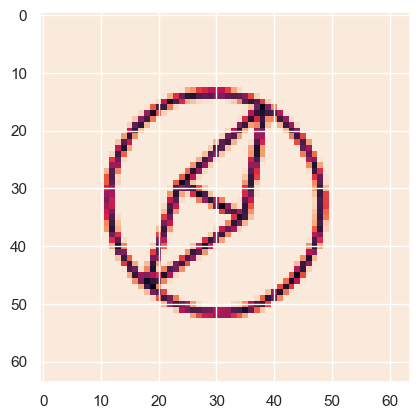

tensor(5)


In [309]:
plt.imshow(X_train[0, 0, :, :])
plt.show()
print(y_train[0])

## Структура неронной сети

In [310]:
class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=0)
        self.act1  = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(13 * 13 * 16, 240)
        self.act3  = torch.nn.ReLU()
        
        self.fc2   = torch.nn.Linear(240, 100)
        self.act4  = torch.nn.ReLU()
        
        self.fc3   = torch.nn.Linear(100, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        # print(f"Размер тензора после 1 слоя: {x.size()}")
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        # print(f"Размер тензора после 2 слоя: {x.size()}")
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        # print(f"Размер тензора после view слоя: {x.size()}")

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
lenet = LeNet()

Девайс на котором будут происходить вычисления

In [311]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet = lenet.to(device)

In [312]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet.parameters(), lr=1.0e-3)

## Процесс обучения

In [313]:
BATCH_SIZE = 50
NUM_EPOCH = 20

test_accuracy_history = []
test_loss_history = []
f1_score_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(NUM_EPOCH):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), BATCH_SIZE):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+BATCH_SIZE]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = lenet.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)

    # print(y_test.numpy())
    # print(test_preds.argmax(dim=1))

    f1 = f1_score(y_test, test_preds.argmax(dim=1).numpy(), average='weighted')  # Используйте average='macro' или 'micro' в зависимости от задачи
    f1_score_history.append(f1)
    

       
    print(accuracy)
    print('F1 Score:', f1)

tensor(0.4500)
F1 Score: 0.39241564445631766
tensor(0.7900)
F1 Score: 0.7691143966695028
tensor(0.9050)
F1 Score: 0.9036767394172536
tensor(0.9500)
F1 Score: 0.949211295552759
tensor(0.9700)
F1 Score: 0.9700478822430043
tensor(0.9900)
F1 Score: 0.9899968730456535
tensor(0.9950)
F1 Score: 0.9949968730456535
tensor(1.)
F1 Score: 1.0
tensor(1.)
F1 Score: 1.0
tensor(1.)
F1 Score: 1.0
tensor(1.)
F1 Score: 1.0
tensor(1.)
F1 Score: 1.0
tensor(1.)
F1 Score: 1.0
tensor(1.)
F1 Score: 1.0
tensor(1.)
F1 Score: 1.0
tensor(1.)
F1 Score: 1.0
tensor(1.)
F1 Score: 1.0
tensor(1.)
F1 Score: 1.0
tensor(1.)
F1 Score: 1.0
tensor(1.)
F1 Score: 1.0


In [340]:
def plot_metric(history, metric_name, title, ylabel, color='blue'):
    """
    Функция для построения графиков метрик.
    
    :param history: Список или массив значений метрики для постройки графика.
    :param metric_name: Название метрики для легенды.
    :param title: Заголовок графика.
    :param ylabel: Метка для оси Y.
    :param color: Цвет линии графика (по умолчанию 'blue').
    """
    plt.style.use('ggplot')  # Выбор стиля графика
    fig, ax = plt.subplots(figsize=(8, 5))
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Эпохи', fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    
    plt.plot(history, label=metric_name, color=color)
    ax.grid(True)
    ax.legend()
    
    plt.show()

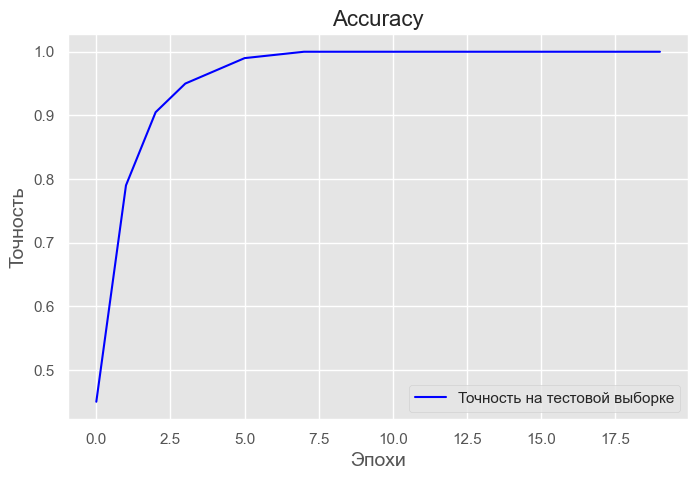

In [344]:
plot_metric(test_accuracy_history, 'Точность на тестовой выборке', 'Accuracy', 'Точность', color='blue')

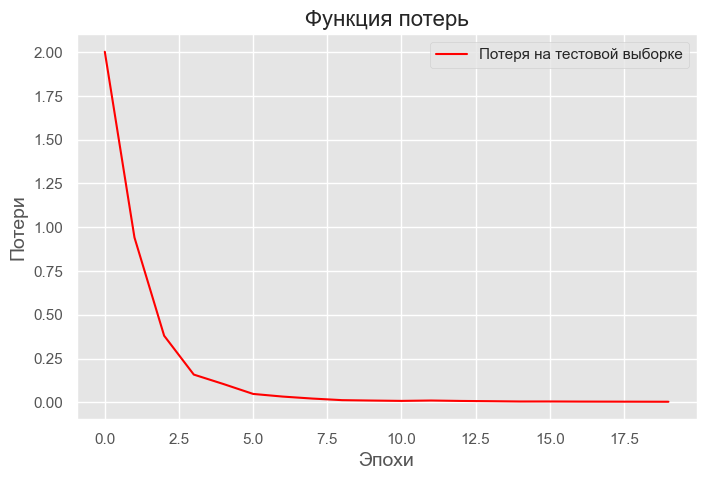

In [345]:
plot_metric(test_loss_history, 'Потеря на тестовой выборке', 'Функция потерь', 'Потери', color='red')

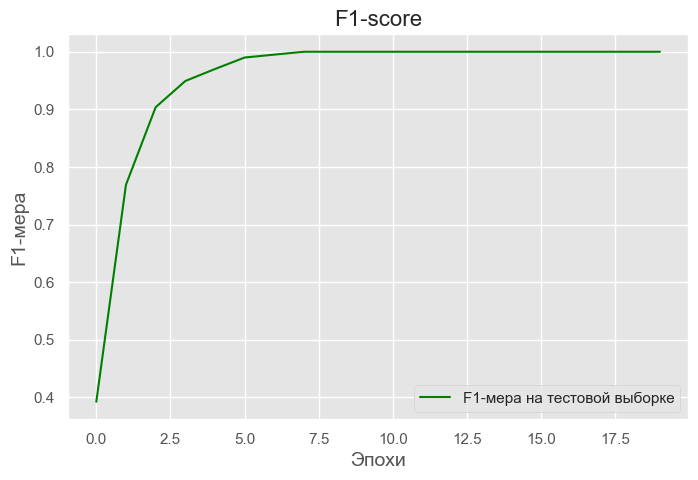

In [347]:
plot_metric(f1_score_history, 'F1-мера на тестовой выборке', 'F1-score', 'F1-мера', color='green')